In [1]:
from pylab import *
import os
import sys
from sklearn.mixture import GaussianMixture
import pickle
from PIL import Image

In [2]:
dataset_dir = 'rgbd_dataset_freiburg3_long_office_household'
depth_dir = 'depth'
gmm_dir = 'gmm_qqvga'

# og 
fx = 525.0  # focal length x
fy = 525.0  # focal length y
cx = 319.5  # optical center x
cy = 239.5  # optical center y

# fri3 
fx = 535.4  # focal length x
fy = 539.2  # focal length y
cx = 320.1  # optical center x
cy = 247.6  # optical center y
factor = 5000 # for the 16-bit PNG files
# OR: factor = 1 # for the 32-bit float images in the ROS bag files

full_depth_dir = os.path.join(dataset_dir,depth_dir)


In [123]:
y_grid = np.repeat(np.arange(480)[:,None],640,1)
x_grid = np.repeat(np.arange(640)[None,:],480,0)

def img_to_pts(img):
    Z = img/factor
    X = (x_grid-cx) * Z /fx
    Y = (y_grid-cy) * Z /fy
    #for v in range(depth_image.height):
    #  for u in range(depth_image.width):
    #    Z = depth_image[v,u] / factor;
    #    X = (u - cx) * Z / fx;
    #    Y = (v - cy) * Z / fy;
    X = X[::4,::4]
    Y = Y[::4,::4]
    Z = Z[::4,::4]

    xl = X[Z > 0]
    yl = Y[Z > 0]
    zl = Z[Z > 0]
    n = zl.shape[0]
    idx = np.random.randint(n, size=n//16)

    return np.vstack([xl,yl,zl]).T

def load_data(file):
    image = Image.open(file)   
    pixel = np.array(image)
    return img_to_pts(pixel)

dataset = []
names = []
for fl in sorted(os.listdir(full_depth_dir)):
    name,ext = os.path.splitext(fl)
    data = load_data(os.path.join(full_depth_dir,fl))
    dataset.append(data)
    names.append(name)


In [124]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

In [125]:
name_times = [float(_) for _ in names]

In [126]:
import pandas as pd
gt = pd.read_csv('rgbd_dataset_freiburg3_long_office_household-groundtruth.txt',' ',comment='#',header=None,names='timestamp tx ty tz qx qy qz qw'.split(' '))
def row_to_vec(row):
    a = np.array(row)
    return a[1:4], a[4:]
from scipy.spatial.distance import cdist, pdist
time_dists = cdist(np.array(gt.timestamp)[:,None],np.array(name_times)[:,None])
matches = time_dists.argmin(axis=0)

start_idx = matches[25]
end_idx = matches[125]

frm = row_to_vec(gt.iloc[start_idx])
to = row_to_vec(gt.iloc[end_idx])
print(gt.timestamp[end_idx] - gt.timestamp[start_idx])

start_idx,end_idx


3.5189998149871826


(77, 429)

In [130]:
for i in range(len(matches)-1):
    f1idx = matches[i]
    f2idx = matches[i+1]
    f1 = row_to_vec(gt.iloc[f1idx])
    f2 = row_to_vec(gt.iloc[f2idx])

    print(f1)

(array([-0.6832,  2.6909,  1.7373]), array([ 3.000e-04,  8.617e-01, -5.072e-01, -1.450e-02]))
(array([-0.6832,  2.6909,  1.7373]), array([ 3.000e-04,  8.617e-01, -5.072e-01, -1.450e-02]))
(array([-0.6832,  2.6909,  1.7373]), array([ 3.000e-04,  8.617e-01, -5.072e-01, -1.450e-02]))
(array([-0.6821,  2.6914,  1.7371]), array([ 3.000e-04,  8.609e-01, -5.085e-01, -1.510e-02]))
(array([-0.6811,  2.6918,  1.7371]), array([ 1.000e-04,  8.610e-01, -5.084e-01, -1.590e-02]))
(array([-0.6797,  2.6921,  1.7373]), array([ 0.    ,  0.861 , -0.5083, -0.0162]))
(array([-0.6785,  2.6925,  1.7375]), array([-3.000e-04,  8.607e-01, -5.088e-01, -1.600e-02]))
(array([-0.6775,  2.6928,  1.7374]), array([-1.000e-04,  8.607e-01, -5.088e-01, -1.660e-02]))
(array([-0.6759,  2.6933,  1.7375]), array([-2.000e-04,  8.611e-01, -5.082e-01, -1.700e-02]))
(array([-0.6749,  2.6938,  1.7375]), array([-3.000e-04,  8.609e-01, -5.085e-01, -1.700e-02]))
(array([-0.6736,  2.6942,  1.7374]), array([-1.000e-04,  8.615e-01, -5.0

(array([1.3461, 0.9978, 1.5471]), array([ 0.3986,  0.748 , -0.4639, -0.2577]))
(array([1.3523, 0.9913, 1.5464]), array([ 0.4039,  0.7476, -0.4624, -0.2532]))
(array([1.3583, 0.9843, 1.5457]), array([ 0.4069,  0.7475, -0.4605, -0.2522]))
(array([1.3656, 0.975 , 1.5451]), array([ 0.4094,  0.747 , -0.4573, -0.2553]))
(array([1.3706, 0.9688, 1.5449]), array([ 0.4114,  0.7465, -0.4554, -0.257 ]))
(array([1.3755, 0.9625, 1.5451]), array([ 0.4143,  0.745 , -0.4543, -0.2588]))
(array([1.3813, 0.9558, 1.5461]), array([ 0.4185,  0.7427, -0.4546, -0.2579]))
(array([1.3858, 0.9513, 1.5467]), array([ 0.4228,  0.7406, -0.4547, -0.257 ]))
(array([1.3904, 0.9474, 1.5479]), array([ 0.4283,  0.7384, -0.4535, -0.2562]))
(array([1.3952, 0.9424, 1.55  ]), array([ 0.4344,  0.7332, -0.4551, -0.258 ]))
(array([1.3992, 0.9374, 1.5527]), array([ 0.4387,  0.73  , -0.4534, -0.2627]))
(array([1.4048, 0.9287, 1.5569]), array([ 0.445 ,  0.7258, -0.4525, -0.2653]))
(array([1.4075, 0.9242, 1.5589]), array([ 0.4486,  0

(array([ 0.4571, -1.1195,  1.4129]), array([ 0.8443,  0.1768, -0.0854, -0.4986]))
(array([ 0.4503, -1.1156,  1.412 ]), array([ 0.8436,  0.1809, -0.0879, -0.4979]))
(array([ 0.4418, -1.1098,  1.4103]), array([ 0.8436,  0.1856, -0.0885, -0.4961]))
(array([ 0.4336, -1.1032,  1.4086]), array([ 0.8422,  0.1899, -0.0886, -0.4967]))
(array([ 0.4271, -1.0983,  1.4075]), array([ 0.8411,  0.1952, -0.092 , -0.4959]))
(array([ 0.4208, -1.0928,  1.406 ]), array([ 0.8416,  0.197 , -0.0932, -0.4941]))
(array([ 0.4121, -1.0847,  1.4043]), array([ 0.8416,  0.1995, -0.095 , -0.4928]))
(array([ 0.4053, -1.0784,  1.4035]), array([ 0.8397,  0.2024, -0.0993, -0.494 ]))
(array([ 0.3988, -1.0717,  1.4018]), array([ 0.84  ,  0.2038, -0.0997, -0.4928]))
(array([ 0.39  , -1.0631,  1.4   ]), array([ 0.8399,  0.2067, -0.1022, -0.4913]))
(array([ 0.3832, -1.0567,  1.3986]), array([ 0.8385,  0.2101, -0.1044, -0.4917]))
(array([ 0.3765, -1.0505,  1.3971]), array([ 0.8385,  0.2126, -0.107 , -0.4902]))
(array([ 0.3675,

(array([-0.8774, -1.0234,  1.2431]), array([ 0.7976,  0.4348, -0.1427, -0.393 ]))
(array([-0.8855, -1.0283,  1.242 ]), array([ 0.7928,  0.4448, -0.1456, -0.3905]))
(array([-0.8925, -1.0316,  1.2417]), array([ 0.7899,  0.4474, -0.1518, -0.3909]))
(array([-0.8992, -1.0345,  1.2415]), array([ 0.7866,  0.4518, -0.1558, -0.3909]))
(array([-0.9083, -1.0382,  1.2414]), array([ 0.7803,  0.4583, -0.1612, -0.3937]))
(array([-0.9146, -1.0412,  1.2419]), array([ 0.7779,  0.4624, -0.1637, -0.3926]))
(array([-0.9215, -1.0439,  1.2419]), array([ 0.7748,  0.4645, -0.1694, -0.3939]))
(array([-0.931 , -1.0479,  1.2419]), array([ 0.7726,  0.4675, -0.1764, -0.3917]))
(array([-0.9377, -1.0502,  1.2415]), array([ 0.7704,  0.4704, -0.1803, -0.3909]))
(array([-0.9444, -1.0525,  1.2407]), array([ 0.7663,  0.475 , -0.185 , -0.3909]))
(array([-0.9532, -1.0552,  1.2397]), array([ 0.7631,  0.4798, -0.1902, -0.3889]))
(array([-0.9597, -1.0569,  1.2381]), array([ 0.7623,  0.4819, -0.1927, -0.3866]))
(array([-0.9656,

(array([-2.1029, -1.409 ,  1.3719]), array([ 0.7819, -0.4347,  0.1868, -0.406 ]))
(array([-2.1068, -1.4039,  1.3708]), array([ 0.7808, -0.4362,  0.1875, -0.4062]))
(array([-2.111 , -1.3984,  1.3698]), array([ 0.779 , -0.4394,  0.1871, -0.4062]))
(array([-2.1146, -1.3938,  1.3692]), array([ 0.7772, -0.443 ,  0.1871, -0.4059]))
(array([-2.1197, -1.3867,  1.3685]), array([ 0.7745, -0.4463,  0.1876, -0.4073]))
(array([-2.1239, -1.3816,  1.3681]), array([ 0.773 , -0.4491,  0.189 , -0.4062]))
(array([-2.1291, -1.3749,  1.3677]), array([ 0.7713, -0.4509,  0.1918, -0.4063]))
(array([-2.1333, -1.3693,  1.3676]), array([ 0.77  , -0.4511,  0.194 , -0.4074]))
(array([-2.137 , -1.364 ,  1.3672]), array([ 0.7697, -0.4506,  0.1956, -0.4077]))
(array([-2.1429, -1.3568,  1.367 ]), array([ 0.7685, -0.4541,  0.197 , -0.4054]))
(array([-2.1518, -1.3456,  1.3664]), array([ 0.767 , -0.454 ,  0.1993, -0.4074]))
(array([-2.1589, -1.3382,  1.3661]), array([ 0.7665, -0.4552,  0.2008, -0.4063]))
(array([-2.1644,

(array([-3.1908,  0.8482,  1.4577]), array([-0.3431,  0.7878, -0.4173,  0.2958]))
(array([-3.1894,  0.8621,  1.4595]), array([-0.3418,  0.7875, -0.4183,  0.2968]))
(array([-3.188 ,  0.8727,  1.4613]), array([-0.3407,  0.7845, -0.4234,  0.2987]))
(array([-3.1859,  0.8872,  1.4639]), array([-0.3423,  0.7807, -0.4273,  0.3013]))
(array([-3.1841,  0.8977,  1.4659]), array([-0.34  ,  0.7802, -0.4283,  0.3037]))
(array([-3.1821,  0.9081,  1.4679]), array([-0.3403,  0.777 , -0.4315,  0.307 ]))
(array([-3.179 ,  0.9216,  1.4706]), array([-0.3414,  0.7726, -0.4356,  0.311 ]))
(array([-3.1759,  0.9308,  1.4719]), array([-0.3411,  0.7721, -0.4356,  0.3126]))
(array([-3.173 ,  0.9401,  1.4733]), array([-0.3414,  0.7711, -0.4371,  0.3127]))
(array([-3.169 ,  0.9524,  1.4751]), array([-0.343 ,  0.7684, -0.4406,  0.3127]))
(array([-3.1658,  0.9615,  1.4763]), array([-0.343 ,  0.768 , -0.4421,  0.3117]))
(array([-3.1624,  0.9704,  1.4774]), array([-0.3432,  0.7675, -0.4433,  0.311 ]))
(array([-3.1535,

(array([-1.1448,  1.2808,  1.3366]), array([ 0.144 ,  0.8856, -0.4415, -0.0026]))
(array([-1.1359,  1.2845,  1.3375]), array([ 0.1426,  0.8856, -0.442 ,  0.0011]))
(array([-1.1244,  1.2894,  1.3387]), array([ 0.1389,  0.885 , -0.4444,  0.002 ]))
(array([-1.1156,  1.293 ,  1.3397]), array([ 0.1363,  0.8844, -0.4463,  0.0025]))
(array([-1.1075,  1.296 ,  1.3406]), array([ 0.1351,  0.884 , -0.4474,  0.0042]))
(array([-1.0963,  1.3001,  1.3418]), array([ 0.1315,  0.8845, -0.4476,  0.0057]))
(array([-1.0882,  1.3028,  1.3432]), array([ 0.1303,  0.8846, -0.4477,  0.0068]))
(array([-1.0805,  1.3051,  1.3446]), array([ 0.128 ,  0.8843, -0.4489,  0.0078]))
(array([-1.0702,  1.3079,  1.3462]), array([ 0.1272,  0.8851, -0.4477,  0.0064]))
(array([-1.0623,  1.3094,  1.3474]), array([ 0.1244,  0.8841, -0.4503,  0.0073]))
(array([-1.0516,  1.3114,  1.349 ]), array([ 0.1237,  0.884 , -0.4508,  0.0097]))
(array([-1.0361,  1.3137,  1.3504]), array([ 0.1225,  0.8844, -0.4502,  0.0092]))
(array([-1.0259,

(array([0.8319, 2.025 , 1.5231]), array([ 0.3219,  0.7754, -0.5235, -0.1451]))
(array([0.8331, 2.0257, 1.5231]), array([ 0.3213,  0.773 , -0.5263, -0.1491]))
(array([0.8351, 2.027 , 1.5233]), array([ 0.3175,  0.7718, -0.5301, -0.15  ]))
(array([0.8363, 2.0279, 1.5233]), array([ 0.3153,  0.7709, -0.533 , -0.1491]))
(array([0.8366, 2.0289, 1.5221]), array([ 0.3152,  0.7694, -0.534 , -0.1533]))
(array([0.837 , 2.0302, 1.5213]), array([ 0.3127,  0.7699, -0.5342, -0.1554]))
(array([0.8367, 2.031 , 1.5209]), array([ 0.3111,  0.7679, -0.5378, -0.1558]))
(array([0.8353, 2.0327, 1.519 ]), array([ 0.3112,  0.7691, -0.5346, -0.1605]))
(array([0.8341, 2.0341, 1.518 ]), array([ 0.3105,  0.7696, -0.5339, -0.1619]))
(array([0.833 , 2.0354, 1.5174]), array([ 0.3093,  0.7678, -0.5374, -0.1616]))
(array([0.831 , 2.0377, 1.5158]), array([ 0.3079,  0.7699, -0.5342, -0.1645]))
(array([0.8292, 2.0393, 1.5145]), array([ 0.3079,  0.7711, -0.532 , -0.1664]))
(array([0.8277, 2.0406, 1.5136]), array([ 0.3053,  0

In [121]:
frm,to

((array([-0.6244,  2.7078,  1.7395]),
  array([ 0.0116,  0.8596, -0.5105, -0.0191])),
 (array([0.284 , 2.4466, 1.6372]),
  array([ 0.0973,  0.8617, -0.4929, -0.0713])))

<IPython.core.display.Javascript object>


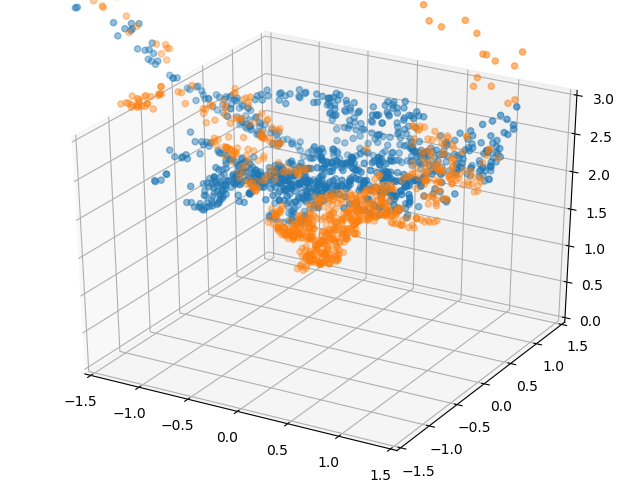

(0, 3)

In [122]:
fig = plt.figure()
ax = Axes3D(fig)

start_frame = dataset[start_idx][np.random.randint(0,dataset[start_idx].shape[0],1000)]
end_frame = dataset[end_idx][np.random.randint(0,dataset[end_idx].shape[0],1000)]

ax.scatter(start_frame[:,0],start_frame[:,1],start_frame[:,2])
ax.scatter(end_frame[:,0],end_frame[:,1],end_frame[:,2])
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_zlim(0,3)

<IPython.core.display.Javascript object>


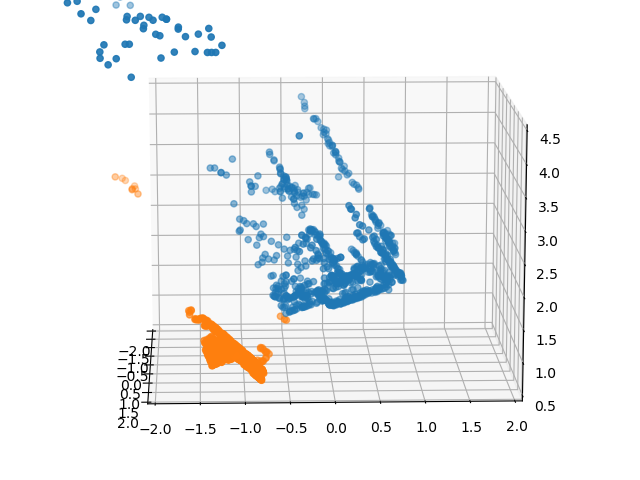

(0.5, 4.5)

In [119]:
import transforms3d
fig = plt.figure()
ax = Axes3D(fig)

start_frame = dataset[start_idx][np.random.randint(0,dataset[start_idx].shape[0],1000)]
end_frame = dataset[end_idx][np.random.randint(0,dataset[end_idx].shape[0],1000)]

r1 = transforms3d.quaternions.quat2mat(to[1])
r2 = transforms3d.quaternions.quat2mat(frm[1])
r1 = np.identity(3)
r2 = np.identity(3)

end_frame = end_frame + (to[0]-frm[0])
end_frame = (r1 @ r2.T @(end_frame - end_frame.mean(0)).T).T + end_frame.mean(0)

ax.scatter(start_frame[:,0],start_frame[:,1],start_frame[:,2])
ax.scatter(end_frame[:,0],end_frame[:,1],end_frame[:,2])
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(0.5,4.5)